# Proyecto: Mapa de Transmisión de Shocks Financieros

## Objetivo
Explorar si el relato de "Bitcoin como oro digital" se sostiene en la práctica o si, por el contrario, BTC se comporta como un activo de riesgo más. Mediante un modelo de clustering sobre la volatilidad semanal de distintos activos, buscamos identificar patrones que revelen si los shocks de mercado son globales o específicos del ecosistema cripto.

## Hipótesis
> La narrativa del "oro digital" frente a la realidad de BTC como activo de riesgo puede medirse objetivamente mediante clustering.

## Pregunta de investigación
> ¿Podemos, al agrupar la volatilidad diaria de cinco activos clave, separar pánicos específicos de cripto de tormentas globales en los mercados tradicionales? El objetivo es ofrecer a los inversionistas un mapa claro de cómo se transmiten los shocks entre Bitcoin y las finanzas tradicionales.

## Universo de activos

| Categoría     | Activo   | Descripción                                           |
|---------------|----------|-------------------------------------------------------|
| Cripto        | BTC-USD  | Bitcoin – foco principal del estudio                 |
|               | ETH-USD  | Ethereum – para contrastar comportamiento cripto     |
| Macroeconómicos | SPY     | ETF que replica el S&P 500 – referencia del mercado accionario estadounidense |
|               | QQQ      | ETF ligado al Nasdaq – sensible a sectores tecnológicos |
|               | VIX      | Índice de volatilidad implícita – mide el miedo del mercado |
| Refugio       | GLD      | ETF de oro – activo tradicionalmente defensivo       |
|               | TLT      | ETF de bonos del Tesoro a 20 años – indicador de refugio y tasa libre de riesgo |

## Periodo de análisis
Desde el **1 de enero de 2018** hasta el **12 de junio de 2025**, con **frecuencia semanal**.

## Fuente de datos
Todos los datos se descargan automáticamente desde **Yahoo Finance** mediante un script reproducible incluido en este repositorio. Los archivos resultantes se guardan como `.csv` listos para su análisis.


## 00 Configuración de la notebook

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# estilo de las visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

SEED = 14
np.random.seed(SEED)

DATA_DIR = Path("../data/raw")
asset_files = {
    'BTC': 'BTC_USD_raw.csv',
    'ETH': 'ETH_USD_raw.csv', 
    'SPY': 'SPY_raw.csv',
    'QQQ': 'QQQ_raw.csv',
    'VIX': '^VIX_raw.csv',  # Note: Should be ^VIX_raw.csv if you fixed the ticker
    'GLD': 'GLD_raw.csv',
    'TLT': 'TLT_raw.csv'
}

In [95]:
sns.set_theme(
    style='dark',  
    rc={
        'axes.facecolor':    '#000814', 
        'figure.facecolor':  '#000814',
        'grid.color':        '#444444',
        'font.family':       'sans-serif',
        'font.sans-serif':   ['Verdana', 'DejaVu Sans'],
        'font.size':         11,
        'axes.labelcolor':   'white',
        'xtick.color':       'white',
        'ytick.color':       'white',
        'text.color':        'white'
    }
)

# Colores por tipo de activo
type_colors = {
    'crypto':    '#ee9b00',
    'equity':    '#ae2012',
    'volatility':'#52b788',
    'safe_haven':'#0466c8'
}
asset_types = {
    'BTC': 'crypto','ETH': 'crypto',
    'SPY': 'equity','QQQ': 'equity',
    'VIX': 'volatility',
    'GLD': 'safe_haven','TLT': 'safe_haven'
}

## 01 Extracción de Datos

#### Carga y exploración de datos

In [53]:
# Cargar los datos en dataframes individuales
data = {}
for asset_name, filename in asset_files.items():
    file_path = DATA_DIR / filename
    if file_path.exists():
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data[asset_name] = df
        print(f"{asset_name}: {len(df)} datapoints desde {df.index.min().date()} hasta {df.index.max().date()}")
    else:
        print(f"{asset_name}: No se encuentra el archivo")
        
print("\n--- Datos Nulos ---")
for asset_name, df in data.items():
    print(f"\n{asset_name}:", df.isnull().sum().sum())
    
print("\n--- Columnas ---")
print(f"  Columnas: {list(df.columns)}")

BTC: 2719 datapoints desde 2018-01-01 hasta 2025-06-11
ETH: 2719 datapoints desde 2018-01-01 hasta 2025-06-11
SPY: 1871 datapoints desde 2018-01-02 hasta 2025-06-11
QQQ: 1871 datapoints desde 2018-01-02 hasta 2025-06-11
VIX: 1871 datapoints desde 2018-01-02 hasta 2025-06-11
GLD: 1871 datapoints desde 2018-01-02 hasta 2025-06-11
TLT: 1871 datapoints desde 2018-01-02 hasta 2025-06-11

--- Datos Nulos ---

BTC: 0

ETH: 0

SPY: 0

QQQ: 0

VIX: 0

GLD: 0

TLT: 0

--- Columnas ---
  Columnas: ['Close', 'High', 'Low', 'Open', 'Volume', 'Ticker']


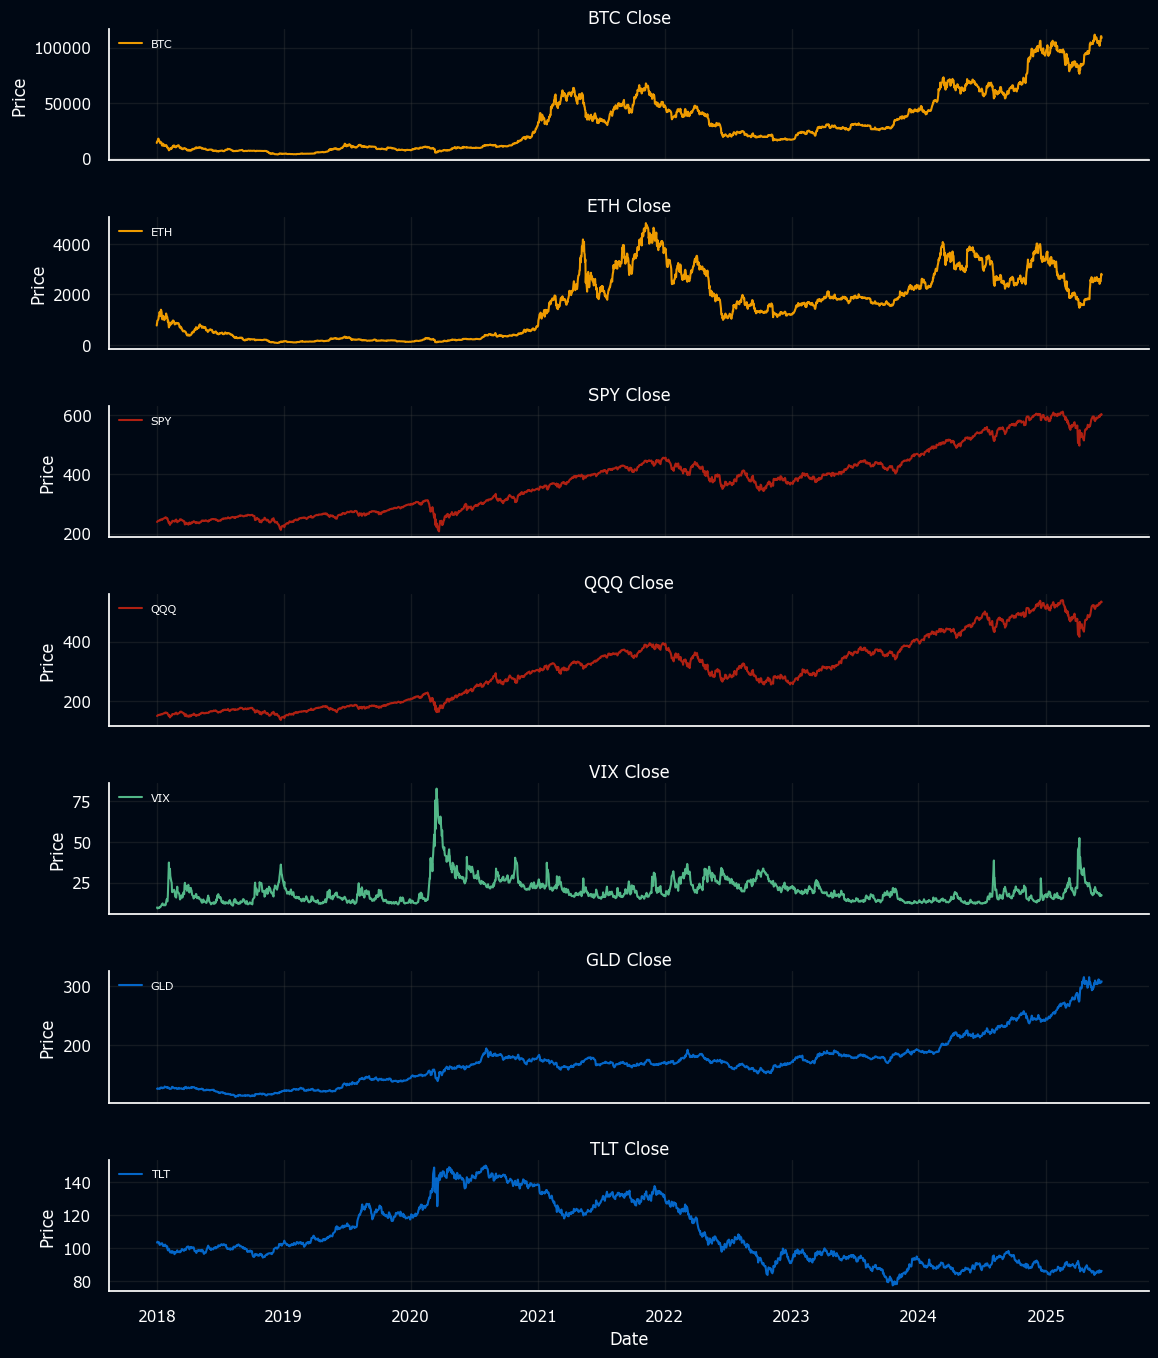

In [96]:
n = len(data)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 2*n), sharex=True)

for ax, ticker in zip(axes, data):
    df = data[ticker]
    ax.plot(df.index, df['Close'],
            color=type_colors[asset_types[ticker]],
            linewidth=1.5, label=ticker)
    ax.set_ylabel('Price')
    ax.set_title(f"{ticker} Close", pad=4)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    # Despine: quitar bordes superior y derecho
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

axes[-1].set_xlabel('Date')
fig.tight_layout(pad=2.0)
plt.show()

### Transformación de datos

In [72]:
# calcular una tabla calendario
start = min(df.index.min() for df in data.values())
end   = max(df.index.max() for df in data.values())
all_days = pd.date_range(start=start, end=end, freq='D')

# lista de DataFrames renombrados y reindexados
dfs = []
for ticker, df in data.items():
    # Añadir columna Ticker para mantener ese dato
    df = df.copy()
    df.drop(columns='Ticker', inplace=True)
    #df['Ticker'] = ticker
    
    # Reindexar a todos los días, conservar NaNs donde falten datos
    df = df.reindex(all_days)
    
    # Renombrar columnas: Close a BTC_close, High a BTC_High, etc.
    rename_map = {col: f"{ticker}_{col}" for col in df.columns}
    df = df.rename(columns=rename_map)
    
    dfs.append(df)

# Concatenar los dataframes para cada activo
daily = pd.concat(dfs, axis=1)

# Dejar la fecha como índice
daily = daily.rename_axis('Date').reset_index()

# Imprimir el dataframe
print(daily.columns.tolist())
daily.head()


['Date', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open', 'BTC_Volume', 'ETH_Close', 'ETH_High', 'ETH_Low', 'ETH_Open', 'ETH_Volume', 'SPY_Close', 'SPY_High', 'SPY_Low', 'SPY_Open', 'SPY_Volume', 'QQQ_Close', 'QQQ_High', 'QQQ_Low', 'QQQ_Open', 'QQQ_Volume', 'VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Open', 'VIX_Volume', 'GLD_Close', 'GLD_High', 'GLD_Low', 'GLD_Open', 'GLD_Volume', 'TLT_Close', 'TLT_High', 'TLT_Low', 'TLT_Open', 'TLT_Volume']


,Date,BTC_Close,BTC_High,BTC_Low,BTC_Open,BTC_Volume,ETH_Close,ETH_High,ETH_Low,ETH_Open,...,GLD_Close,GLD_High,GLD_Low,GLD_Open,GLD_Volume,TLT_Close,TLT_High,TLT_Low,TLT_Open,TLT_Volume
0,2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000,772.640991,782.530029,742.004028,755.757019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192,884.443970,914.830017,772.346008,772.346008,...,125.150002,125.180000,124.389999,124.660004,11762500.0,103.207558,104.046446,102.862136,104.029994,16238200.0
2,2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160,962.719971,974.471008,868.450989,886.000000,...,124.820000,125.089996,124.099998,125.050003,7904300.0,103.700996,103.791465,103.207536,103.626980,8605100.0
3,2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744,980.921997,1045.079956,946.085999,961.713013,...,125.459999,125.849998,124.739998,124.889999,7329700.0,103.684586,103.758608,103.108882,103.339164,9217900.0
4,2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072,997.719971,1075.390015,956.325012,975.750000,...,125.330002,125.480003,124.830002,124.930000,5739900.0,103.388519,103.775066,103.100668,103.520112,10915400.0


### Datos Diarios

In [ ]:
etf_tickers   = ['SPY','QQQ','VIX','GLD','TLT']

daily = daily.set_index('Date')

for t in etf_tickers:
    cols = [f"{t}_{c}" for c in ['Close', 'High','Low','Open','Volume']]
    daily[cols] = daily[cols].ffill(limit=3)
    
print(daily.isna().sum())

BTC_Close     0
BTC_High      0
BTC_Low       0
BTC_Open      0
BTC_Volume    0
ETH_Close     0
ETH_High      0
ETH_Low       0
ETH_Open      0
ETH_Volume    0
SPY_Close     1
SPY_High      1
SPY_Low       1
SPY_Open      1
SPY_Volume    1
QQQ_Close     1
QQQ_High      1
QQQ_Low       1
QQQ_Open      1
QQQ_Volume    1
VIX_Close     1
VIX_High      1
VIX_Low       1
VIX_Open      1
VIX_Volume    1
GLD_Close     1
GLD_High      1
GLD_Low       1
GLD_Open      1
GLD_Volume    1
TLT_Close     1
TLT_High      1
TLT_Low       1
TLT_Open      1
TLT_Volume    1
dtype: int64


In [74]:
# Calcular log_ret diario basado en Close
tickers = list(data.keys())
for ticker in tickers:
    close_col = f"{ticker}_Close"
    logret_col = f"{ticker}_log_ret"
    # log_ret = log(Close_t) - log(Close_{t-1})
    daily[logret_col] = np.log(daily[close_col]).diff()

daily[[f"{t}_log_ret" for t in tickers]].head()

,BTC_log_ret,ETH_log_ret,SPY_log_ret,QQQ_log_ret,VIX_log_ret,GLD_log_ret,TLT_log_ret
Date,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.092589,0.135145,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.014505,0.084803,0.006305,0.009670,-0.065563,-0.002640,0.004770
2018-01-04,0.025858,0.018730,0.004206,0.001748,0.007621,0.005114,-0.000158
2018-01-05,0.110945,0.016980,0.006642,0.009993,0.000000,-0.001037,-0.002860


### Datos semanales (cada viernes) agregados

In [80]:
# Definir funciones de agregación por ticker
agg_funcs = {}
for t in data.keys():
    agg_funcs.update({
        f"{t}_Close":   'last',
        f"{t}_Open":    'first',             
        f"{t}_High":    'max',               
        f"{t}_Low":     'min',               
        f"{t}_Volume":  'sum',               
        f"{t}_log_ret": lambda x: x.std() * np.sqrt(5)  
    })

# Resampleo semanal al viernes 
weekly = (
    daily
    .resample('W-FRI')
    .agg(agg_funcs)
)

# Confirmar que no haya semanas incompletas
print(f"Semanas incompletas {weekly.isna().sum().sum()}")

weekly.index.name = 'Date'
weekly.head()



Semanas incompletas 0


,BTC_Close,BTC_Open,BTC_High,BTC_Low,BTC_Volume,BTC_log_ret,ETH_Close,ETH_Open,ETH_High,ETH_Low,...,GLD_High,GLD_Low,GLD_Volume,GLD_log_ret,TLT_Close,TLT_Open,TLT_High,TLT_Low,TLT_Volume,TLT_log_ret
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-05,17429.500000,14112.200195,17705.199219,13154.700195,89633799168,0.107153,997.719971,755.757019,1075.390015,742.004028,...,125.849998,124.099998,32736400.0,0.009153,103.388519,104.029994,104.046446,102.862136,44976600.0,0.008650
2018-01-12,13980.599609,17462.099609,17712.400391,13105.900391,116355100672,0.128675,1273.199951,995.153992,1417.380005,994.622009,...,127.129997,124.230003,54262700.0,0.011520,102.409813,103.520112,103.775066,100.880080,83708500.0,0.012581
2018-01-19,11607.400391,13952.400391,14659.500000,9402.290039,100043699200,0.166044,1039.099976,1270.469971,1432.880005,780.921997,...,127.220001,125.800003,61053300.0,0.008704,101.209076,102.064391,103.330951,101.143286,69632400.0,0.009756
2018-01-26,11171.400391,11656.200195,13103.000000,10129.700195,70495249408,0.152328,1055.170044,1044.949951,1167.109985,920.539978,...,129.509995,126.279999,63507500.0,0.012777,101.644958,101.488708,102.146645,100.781409,71734100.0,0.010282
2018-02-02,8830.750000,11174.900391,12040.299805,7796.490234,62406309888,0.132501,915.784973,1055.750000,1257.770020,757.979980,...,128.520004,125.959999,73412600.0,0.014589,98.551765,101.883466,101.908144,98.271551,97835500.0,0.015318


In [82]:
weekly.to_csv("../data/processed/weekly_data.csv")

## 02 Feature Engineering

In [83]:
# Renombrar volatilidades semanales a sigma_TICKER
for t in data.keys():
    old = f"{t}_log_ret"
    new = f"sigma_{t}"
    weekly.rename(columns={old: new}, inplace=True)

# Calcular ratios vs Oro y vs SPY
weekly['ratio_BTC_GLD'] = weekly['sigma_BTC'] / weekly['sigma_GLD']
weekly['ratio_BTC_SPY'] = weekly['sigma_BTC'] / weekly['sigma_SPY']
weekly['ratio_ETH_GLD'] = weekly['sigma_ETH'] / weekly['sigma_GLD']
weekly['ratio_ETH_SPY'] = weekly['sigma_ETH'] / weekly['sigma_SPY']

# Seleccionar sólo las columnas core del modelo
feature_cols = (
    [f"sigma_{t}" for t in data.keys()] +
    ['ratio_BTC_GLD', 'ratio_BTC_SPY', 'ratio_ETH_GLD', 'ratio_ETH_SPY']
)

features = weekly[feature_cols].copy()

print(features.head())
print(features.columns.tolist())


            sigma_BTC  sigma_ETH  sigma_SPY  sigma_QQQ  sigma_VIX  sigma_GLD  \
Date                                                                           
2018-01-05   0.107153   0.127505   0.002952   0.010442   0.089965   0.009153   
2018-01-12   0.128675   0.174927   0.007516   0.008430   0.060875   0.011520   
2018-01-19   0.166044   0.203594   0.009738   0.009805   0.144588   0.008704   
2018-01-26   0.152328   0.152036   0.010616   0.017055   0.054593   0.012777   
2018-02-02   0.132501   0.201897   0.018538   0.017915   0.283106   0.014589   

            sigma_TLT  ratio_BTC_GLD  ratio_BTC_SPY  ratio_ETH_GLD  \
Date                                                                 
2018-01-05   0.008650      11.706432      36.295060      13.929935   
2018-01-12   0.012581      11.169646      17.119272      15.184612   
2018-01-19   0.009756      19.075968      17.051699      23.389954   
2018-01-26   0.010282      11.922419      14.348455      11.899521   
2018-02-02   0.0153

### Escalamiento

In [86]:
df_feats = features.copy()

# log1p volatilidades para reucir las colas
vol_cols = [c for c in df_feats if c.startswith('sigma_')]
df_feats[vol_cols] = np.log1p(df_feats[vol_cols])

# log ratios para reucir las colas

ratio_cols = [c for c in df_feats if c.startswith('ratio_')]
df_feats[ratio_cols] = np.log(df_feats[ratio_cols])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feats)

# opcional: volver a DataFrame para inspección
X_scaled = pd.DataFrame(X_scaled, index=df_feats.index, columns=df_feats.columns)


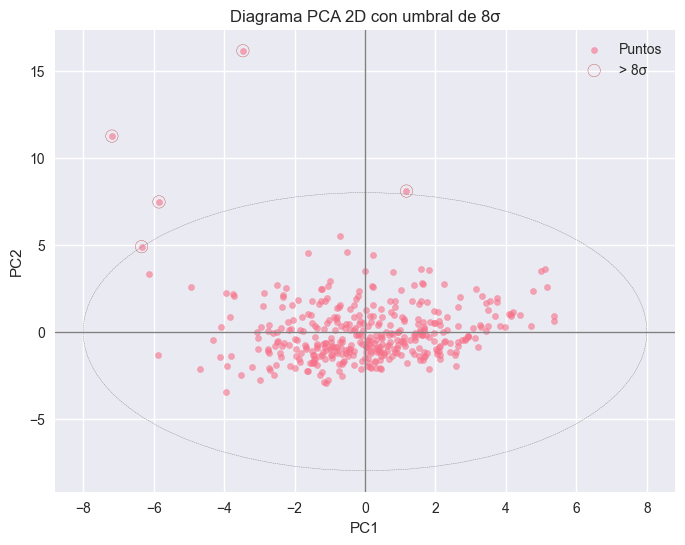

In [88]:
# PCA rápido a 2 componentes
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# Cálculo de distancia al origen
distances = np.sqrt((X_pca ** 2).sum(axis=1))

# Scatter plot con umbral de 8σ
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_pca[:, 0], X_pca[:, 1], s=20, alpha=0.6, label='Puntos')
outliers = distances > 8
if outliers.any():
    ax.scatter(X_pca[outliers, 0], X_pca[outliers, 1],
               facecolors='none', edgecolors='r', s=80, label='> 8σ')

# Añadir círculo de radio 8
circle = plt.Circle((0, 0), 8, color='gray', fill=False, linestyle='--')
ax.add_patch(circle)

# Ejes y leyenda
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Diagrama PCA 2D con umbral de 8σ')
ax.legend()
plt.show()


## 03 Clustering

### Selección del número de Clusters

In [91]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Parámetros
ks = range(2, 11)       # de 2 a 10 clústers
seed = SEED             # tu semilla definida anteriormente

# Lista para acumular resultados
results = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=seed)
    labels = km.fit_predict(X_scaled)
    
    results.append({
        'n_clusters': k,
        'silhouette_score': silhouette_score(X_scaled, labels),
        'davies_bouldin_score': davies_bouldin_score(X_scaled, labels),
        'calinski_harabasz_score': calinski_harabasz_score(X_scaled, labels)
    })

# Crear DataFrame de métricas
df_metrics = pd.DataFrame(results)

# Mostrar resumen
print(df_metrics)


   n_clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score
0           2          0.230379              1.549328               121.373167
1           3          0.242557              1.273691               114.353245
2           4          0.176727              1.457572               102.161191
3           5          0.193500              1.363448               102.418785
4           6          0.171934              1.364877                94.447149
5           7          0.181974              1.369764                89.947841
6           8          0.154178              1.440549                86.075357
7           9          0.157569              1.406945                81.521315
8          10          0.140382              1.450670                76.206608


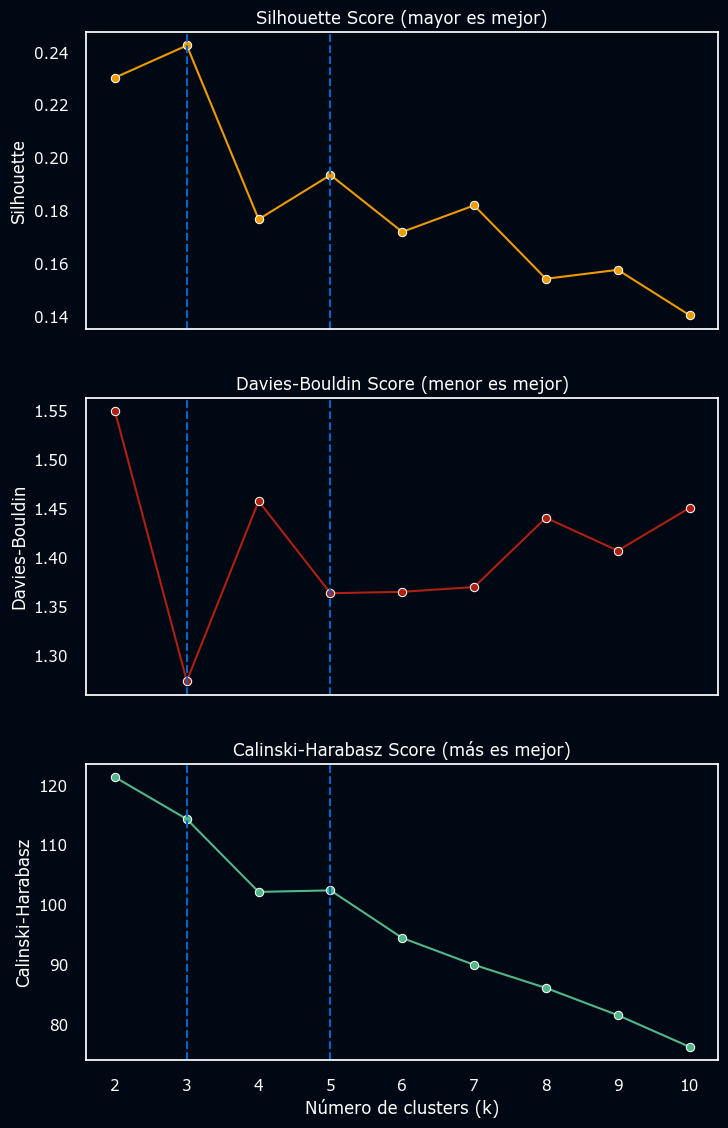

In [98]:
# Colores 
COLOR_SIL = "#ee9b00"   # Silhouette
COLOR_DB  = "#ae2012"   # Davies-Bouldin
COLOR_CH  = "#52b788"   # Calinski-Harabasz
HIGHLIGHT_COLOR = "#0466c8"  # para k=3 y k=5

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# 1) Silhouette 
sns.lineplot(
    x='n_clusters', y='silhouette_score', data=df_metrics,
    ax=axes[0], marker='o', color=COLOR_SIL
)
axes[0].axvline(3, color=HIGHLIGHT_COLOR, linestyle='--')
axes[0].axvline(5, color=HIGHLIGHT_COLOR, linestyle='--')
axes[0].set_title('Silhouette Score (mayor es mejor)')  
axes[0].set_ylabel('Silhouette')


# 2) Davies-Bouldin 
sns.lineplot(
    x='n_clusters', y='davies_bouldin_score', data=df_metrics,
    ax=axes[1], marker='o', color=COLOR_DB
)
axes[1].axvline(3, color=HIGHLIGHT_COLOR, linestyle='--')
axes[1].axvline(5, color=HIGHLIGHT_COLOR, linestyle='--')
axes[1].set_title('Davies-Bouldin Score (menor es mejor)')  
axes[1].set_ylabel('Davies-Bouldin')

# 3) Calinski-Harabasz
sns.lineplot(
    x='n_clusters', y='calinski_harabasz_score', data=df_metrics,
    ax=axes[2], marker='o', color=COLOR_CH
)
axes[2].axvline(3, color=HIGHLIGHT_COLOR, linestyle='--')
axes[2].axvline(5, color=HIGHLIGHT_COLOR, linestyle='--')
axes[2].set_title('Calinski-Harabasz Score (más es mejor)')  
axes[2].set_ylabel('Calinski-Harabasz')
axes[2].set_xlabel('Número de clusters (k)')

# Ajustes generales
plt.tight_layout(pad=3)
plt.show()


### Evaluación de los clusters

In [ ]:
models = {
    3: KMeans(n_clusters=3, random_state=42),
    5: KMeans(n_clusters=5, random_state=42)
}

results = {}

for k, km in models.items():
    # Entrena y obtiene etiquetas
    labels = km.fit_predict(X_scaled)
    
    # Centroides como DataFrame con nombres de columna
    centroids = pd.DataFrame(
        km.cluster_centers_,
        columns=features.columns
    )
    
    # Silhouette
    sil = silhouette_score(X_scaled, labels)
    
    # Guardar todo en el diccionario
    results[k] = {
        "labels": labels,
        "centroids": centroids,
        "silhouette": sil
    }

k=3 → silhouette = 0.1543
k=5 → silhouette = 0.1964


Centroides k=3 ordenados por sigma_BTC y sigma_SPY:
   sigma_BTC  sigma_ETH  sigma_SPY  sigma_QQQ  sigma_VIX  sigma_GLD  \
2   0.604781   0.613628  -0.649610  -0.710021  -0.487738  -0.465821   
1   0.173933   0.134420   0.130453   0.175560   0.221179  -0.211198   
0  -0.618190  -0.577754   0.290744   0.278988   0.073316   0.567008   

   sigma_TLT  ratio_BTC_GLD  ratio_BTC_SPY  ratio_ETH_GLD  ratio_ETH_SPY  
2  -0.552566       0.854633       1.232975       0.891989       1.276596  
1  -0.002419       0.321466      -0.013555       0.275886      -0.068483  
0   0.380704      -0.962613      -0.827191      -0.934534      -0.792397  
Centroides k=5 ordenados por sigma_BTC y sigma_SPY:
   sigma_BTC  sigma_ETH  sigma_SPY  sigma_QQQ  sigma_VIX  sigma_GLD  \
4   3.311108   3.203803   5.117712   4.553555   2.566969   2.422659   
2   0.559552   0.566282  -0.650345  -0.697362  -0.532482  -0.439870   
1   0.392860   0.376174   0.354806   0.443377   0.617127  -0.487300   
3  -0.246513  -0.151667   0

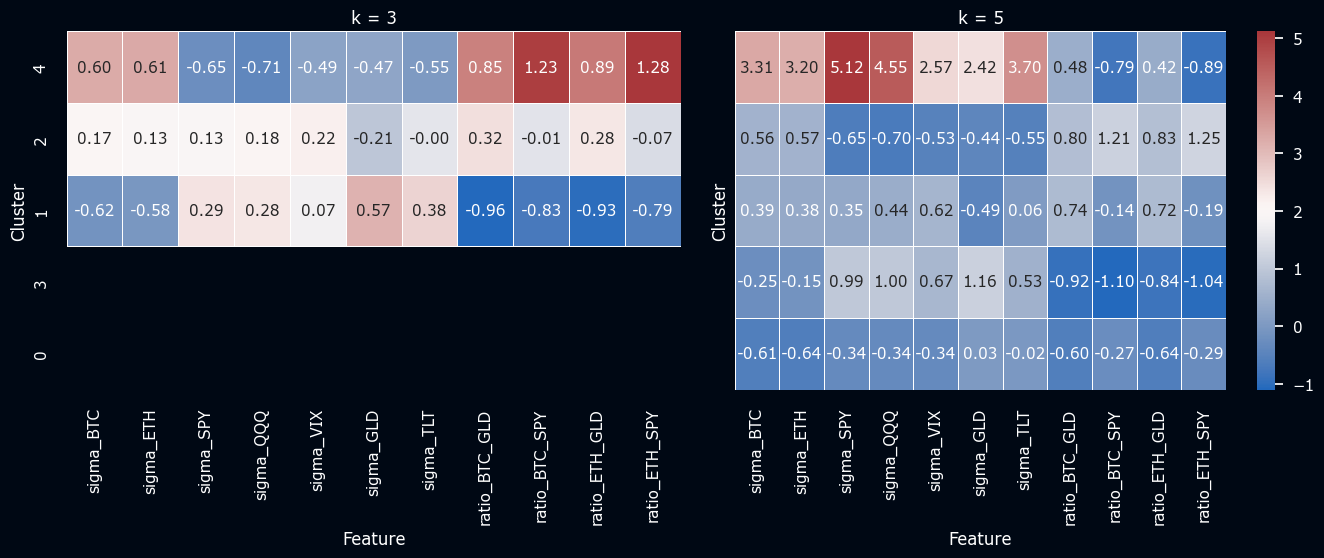

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Mostrar centroides ordenados
for k in [3, 5]:
    cen = results[k]['centroids'].copy()
    # Ordenar por sigma_BTC y luego sigma_SPY (descendente para ubicar más volátiles primero)
    cen_sorted = cen.sort_values(by=['sigma_BTC', 'sigma_SPY'], ascending=False)
    print(f"Centroides k={k} ordenados por sigma_BTC y sigma_SPY:")
    print(cen_sorted)

# 2️⃣ Heat-map lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, k in zip(axes, [3, 5]):
    cen = results[k]['centroids']
    cen = cen.sort_values(by=['sigma_BTC', 'sigma_SPY'], ascending=False)
    sns.heatmap(
        cen,
        annot=True,
        fmt=".2f",
        cmap="vlag",
        ax=ax,
        cbar=(ax is axes[-1]),  # una sola barra de color a la derecha
        linewidths=0.5
    )
    ax.set_title(f"k = {k}")
    ax.set_ylabel("Cluster")
    ax.set_xlabel("Feature")

plt.tight_layout(pad=2)
plt.show()

### Perfilamiento

In [102]:
# Definir nombres para los clusters
map_k3 = {
    2: "Crypto-Only Panic",    # σ_BTC↑, σ_SPY↓
    1: "Neutral / Transition",
    0: "Flight-to-Safety",     # Risk-off, BTC se calma
}

map_k5 = {
    4: "Systemic Shock XL",    # COVID, SVB…
    2: "Crypto-Only Panic",
    1: "Mild Storm",
    3: "Classic Risk-Off",
    0: "Quiet / Drift",
}

# Etiquetar y mostrar centroides con nombres
for k, cmap in [(3, map_k3), (5, map_k5)]:
    cent = results[k]['centroids'].copy()
    cent['cluster_name'] = cent.index.map(cmap)
    print(f"\nCentroides etiquetados k={k}:")
    display(cent)



Centroides etiquetados k=3:


,sigma_BTC,sigma_ETH,sigma_SPY,sigma_QQQ,sigma_VIX,sigma_GLD,sigma_TLT,ratio_BTC_GLD,ratio_BTC_SPY,ratio_ETH_GLD,ratio_ETH_SPY,cluster_name
0,-0.618190,-0.577754,0.290744,0.278988,0.073316,0.567008,0.380704,-0.962613,-0.827191,-0.934534,-0.792397,Flight-to-Safety
1,0.173933,0.134420,0.130453,0.175560,0.221179,-0.211198,-0.002419,0.321466,-0.013555,0.275886,-0.068483,Neutral / Transition
2,0.604781,0.613628,-0.649610,-0.710021,-0.487738,-0.465821,-0.552566,0.854633,1.232975,0.891989,1.276596,Crypto-Only Panic



Centroides etiquetados k=5:


,sigma_BTC,sigma_ETH,sigma_SPY,sigma_QQQ,sigma_VIX,sigma_GLD,sigma_TLT,ratio_BTC_GLD,ratio_BTC_SPY,ratio_ETH_GLD,ratio_ETH_SPY,cluster_name
0,-0.612493,-0.637365,-0.337478,-0.336709,-0.338079,0.033684,-0.019990,-0.602184,-0.267001,-0.637865,-0.285466,Quiet / Drift
1,0.392860,0.376174,0.354806,0.443377,0.617127,-0.487300,0.061401,0.739580,-0.137849,0.722726,-0.187065,Mild Storm
2,0.559552,0.566282,-0.650345,-0.697362,-0.532482,-0.439870,-0.551035,0.801397,1.205958,0.834951,1.247232,Crypto-Only Panic
3,-0.246513,-0.151667,0.992443,1.002067,0.669666,1.158590,0.531505,-0.916836,-1.100543,-0.844724,-1.036568,Classic Risk-Off
4,3.311108,3.203803,5.117712,4.553555,2.566969,2.422659,3.696963,0.476559,-0.786976,0.418972,-0.885827,Systemic Shock XL


In [104]:

map_k3 = {
    2: "Crypto-Only Panic",
    1: "Neutral / Transition",
    0: "Flight-to-Safety",
}
map_k5 = {
    4: "Systemic Shock XL",
    2: "Crypto-Only Panic",
    1: "Mild Storm",
    3: "Classic Risk-Off",
    0: "Quiet / Drift",
}

# Fechas representativas (viernes) para cada evento
event_dates = {
    'COVID-19 Mar-2020': '2020-03-20',
    'FTX Nov-2022': '2022-11-11',
    'BTC ETF hype Oct-2023': '2023-10-13',
    'Semana cualquiera Abr-2021': '2021-04-09'
}

# Construir filas con asignación de clusters
rows = []
for event, date_str in event_dates.items():
    date = pd.to_datetime(date_str)
    # Encuentra el viernes de cierre más cercano previo o igual
    week = weekly.index.asof(date)
    idx = weekly.index.get_loc(week)
    label3 = results[3]['labels'][idx]
    label5 = results[5]['labels'][idx]
    rows.append({
        'Evento': event,
        'Semana (viernes)': week.date(),
        'k=3 etiqueta': label3,
        'k=3 nombre': map_k3[label3],
        'k=5 etiqueta': label5,
        'k=5 nombre': map_k5[label5],
    })

df_events = pd.DataFrame(rows)

print(df_events)

                       Evento Semana (viernes)  k=3 etiqueta  \
0           COVID-19 Mar-2020       2020-03-20             0   
1                FTX Nov-2022       2022-11-11             1   
2       BTC ETF hype Oct-2023       2023-10-13             0   
3  Semana cualquiera Abr-2021       2021-04-09             1   

             k=3 nombre  k=5 etiqueta         k=5 nombre  
0      Flight-to-Safety             4  Systemic Shock XL  
1  Neutral / Transition             4  Systemic Shock XL  
2      Flight-to-Safety             3   Classic Risk-Off  
3  Neutral / Transition             2  Crypto-Only Panic  


In [105]:
# Eventos clave y sus fechas
event_dates = {
    'Crypto-Winter 2018 (BTC < $6k)':      '2018-12-14',
    'Flash-Crash Volmageddon':            '2018-02-09',
    'COVID-19 “Black Thursday”':          '2020-03-20',
    'Rally post-COVID & Halving BTC':     '2020-08-21',
    'China & Tesla crackdown':            '2021-05-21',
    'ATH Bitcoin ≈ $69k':                  '2021-11-12',
    'Colapso Terra/LUNA-UST':             '2022-05-13',
    'Inflación 9.1% (CPI)':               '2022-07-15',
    'FTX Chapter 11':                     '2022-11-11',
    'Quiebra SVB / Banca Regional USA':   '2023-03-17',
    'ETF Spot hype (BlackRock filing)':   '2023-10-13',
    'Aprobación ETFs Spot BTC (SEC)':     '2024-01-12',
}

rows = []
for event, date_str in event_dates.items():
    date = pd.to_datetime(date_str)
    # Encuentra el viernes de cierre más cercano previo o igual
    week = weekly.index.asof(date)
    idx = weekly.index.get_loc(week)
    lab3 = results[3]['labels'][idx]
    lab5 = results[5]['labels'][idx]
    rows.append({
        'Evento': event,
        'Semana (viernes)': week.date(),
        'k=3 etiqueta': lab3,
        'k=3 nombre': map_k3.get(lab3, str(lab3)),
        'k=5 etiqueta': lab5,
        'k=5 nombre': map_k5.get(lab5, str(lab5)),
    })

df_events = pd.DataFrame(rows)

print(df_events)

                              Evento Semana (viernes)  k=3 etiqueta  \
0     Crypto-Winter 2018 (BTC < $6k)       2018-12-14             1   
1            Flash-Crash Volmageddon       2018-02-09             1   
2          COVID-19 “Black Thursday”       2020-03-20             0   
3     Rally post-COVID & Halving BTC       2020-08-21             0   
4            China & Tesla crackdown       2021-05-21             2   
5                 ATH Bitcoin ≈ $69k       2021-11-12             1   
6             Colapso Terra/LUNA-UST       2022-05-13             1   
7               Inflación 9.1% (CPI)       2022-07-15             1   
8                     FTX Chapter 11       2022-11-11             1   
9   Quiebra SVB / Banca Regional USA       2023-03-17             0   
10  ETF Spot hype (BlackRock filing)       2023-10-13             0   
11    Aprobación ETFs Spot BTC (SEC)       2024-01-12             2   

              k=3 nombre  k=5 etiqueta         k=5 nombre  
0   Neutral / Tr

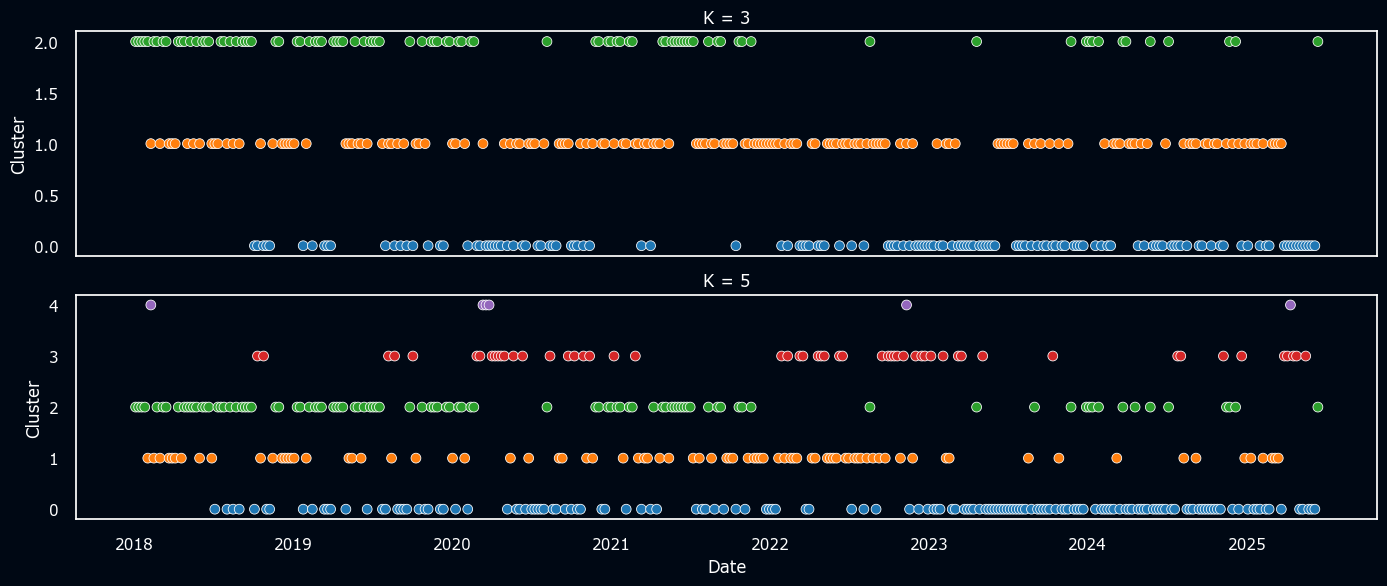

In [106]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for ax, k in zip(axes, [3, 5]):
    sns.scatterplot(
        x=weekly.index, 
        y=results[k]['labels'], 
        hue=results[k]['labels'],
        palette='tab10',
        legend=False,
        s=50,
        ax=ax
    )
    ax.set_title(f"K = {k}")
    ax.set_ylabel("Cluster")
    
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


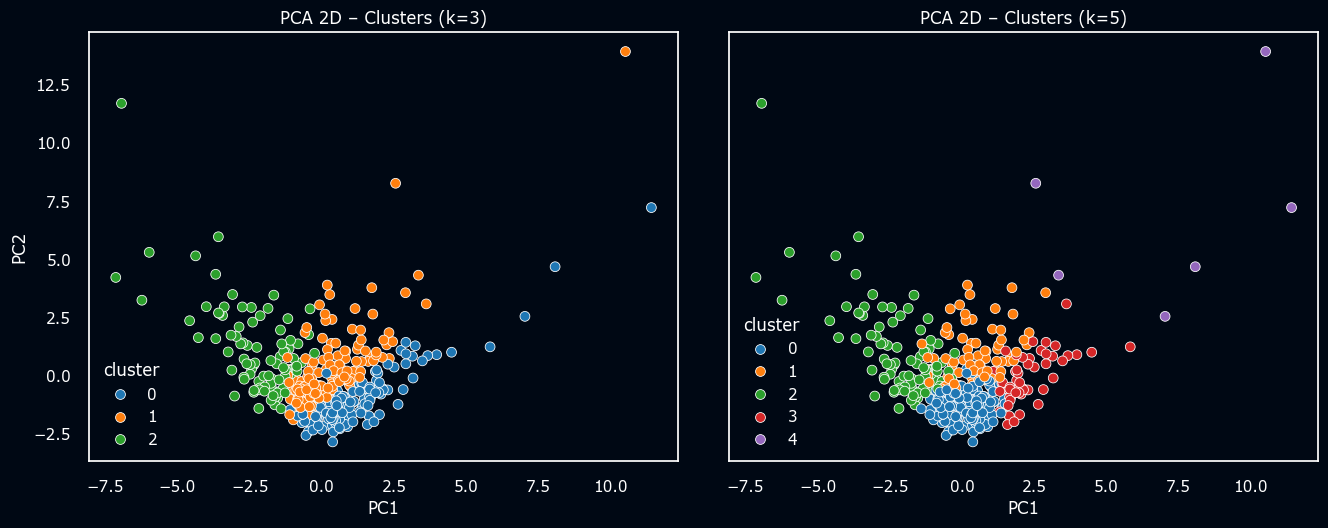

In [107]:
# 1. Prepara los datos de PCA (asegura tener 'features' definido)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# DataFrame para graficar
df_pca = pd.DataFrame(
    X_pca, 
    index=weekly.index, 
    columns=['PC1', 'PC2']
)

# 2. Dibuja dos subplots, uno para k=3 y otro para k=5
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, k in zip(axes, [3, 5]):
    # Añadir columna de cluster al df_pca
    df_plot = df_pca.copy()
    df_plot['cluster'] = results[k]['labels']
    
    sns.scatterplot(
        data=df_plot,
        x='PC1', y='PC2',
        hue='cluster',
        palette='tab10',
        ax=ax,
        s=50,
        legend='full'
    )
    ax.set_title(f'PCA 2D – Clusters (k={k})')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Ajustes finales
plt.tight_layout(pad=3)
plt.show()


In [108]:
for k in [3, 5]:
    counts = pd.Series(results[k]['labels']).value_counts().sort_index()
    print(f"\nCluster counts for k={k}:")
    print(counts)


Cluster counts for k=3:
0    136
1    160
2     93
Name: count, dtype: int64

Cluster counts for k=5:
0    151
1     82
2     96
3     54
4      6
Name: count, dtype: int64
